This is a companion notebook based on information in [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff). The material and examples are provided by [François Chollet](https://fchollet.com/).

This notebook was generated for TensorFlow 2.6.

# Getting started with neural networks: Classification and regression

We will start by covering the three most common 
use cases of neural networks— binary classification, multiclass classification,
and scalar regression:

*   Classifying movie reviews as positive or negative (binary classification)
*   Classifying news wires by topic (multiclass classification)
* Estimating the price of a house, given real-estate data (scalar regression)



These examples will demonstrate end-to-end machine learning work-
flows: you'll get introduced to data preprocessing, basic model architecture principles, and model evaluation.


---
**Classification and regression glossary**

Classification and regression involve many specialized terms. They have precise, machine learning-specific definitions, including:

* **Sample** or **input**- One data point that goes into your model.
* **Prediction** or **output**- What comes out of your model.
* **Target**- The truth. What your model should ideally have predicted, according to an external source of data.
* **Prediction  error**  or  **loss  value** — A  measure  of  the  distance  between  your model's prediction and the target.
* **Classes**— A set of possible labels to choose from in a classification problem. For example, when classifying cat and dog pictures, “dog” and “cat” are the two classes.
*  **Label** — A specific instance of a class annotation in a classification problem. For  instance,  if  picture  #1234  is  annotated  as  containing  the  class  “dog,” then “dog” is a label of picture #1234.
* **Ground-truth**  or  **annotations** — All  targets  for  a  dataset,  typically  collected  by humans.
* **Binary  classification** — A  classification  task  where  each  input  sample  should be categorized into two exclusive categories.
* **Multiclass  classification** — A  classification  task  where  each  input  sample should be categorized into more than two categories: for instance, classifying handwritten digits.
* **Multilabel  classification** — A  classification  task  where  each  input  sample  can be assigned multiple labels. For instance, a given image may contain both a cat  and  a  dog  and  should  be  annotated  both  with  the  “cat”  label  and  the “dog” label. The number of labels per image is usually variable.
* **Scalar regression** — A task where the target is a continuous scalar value. Predicting house prices is a good example: the different target prices form a continuous space.
* **Vector regression** — A task where the target is a set of continuous values: for example, a continuous vector. If you're doing regression against multiple values  (such  as  the  coordinates  of  a  bounding  box  in  an  image),  then  you're doing vector regression.
* **Mini-batch**  or  **batch**- A  small  set  of  samples  (typically  between  8  and  128) that are processed simultaneously by the model. The number of samples is often a power of 2, to facilitate memory allocation on GPU. When training, a
mini-batch  is  used  to  compute  a  single  gradient-descent  update  applied  to the weights of the model.
---

## Classifying movie reviews: A binary classification example

Two-class  classification, or  binary  classification, is  one of  the  most  common  kinds of machine learning problems. In this example, you’ll learn to classify movie reviews as positive or negative, based on the text content of the reviews.



### The IMDB dataset

You'll work with the IMDB dataset: a set of 50,000 highly polarized reviews from the Internet Movie Database.  They're  split  into  25,000  reviews  for  training  and  25,000 reviews for testing, each set consisting of 50% negative and 50% positive reviews.


 Just like the MNIST dataset, the IMDB dataset comes packaged with Keras. It has
already  been  preprocessed:  the  reviews  (sequences of words)  have been  turned  into sequences  of  integers,  where  each  integer  stands  for  a  specific  word  in  a  dictionary. This enables us to focus on model building, training, and evaluation.

The following code will load the dataset (when you run it the first time, about 80 MB of data will be downloaded to your machine).

**Loading the IMDB dataset**

In [ ]:
from tensorflow.keras.datasets import imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(
    num_words=10000)

The argument `num_words=10000` means you’ll only keep the top 10,000 most frequently occurring words in the training data. Rare words will be discarded. This allows us to work with vector data of manageable size. If we didn't set this limit, we'd be working with 88,585 unique words in the training data, which is unnecessarily large.  Many of these words only occur in a single sample, and thus can't be meaningfully used for classification.

The variables `train_data` and `test_data` are lists of reviews; each review is a list of word indices (encoding a sequence of words). `train_labels` and `test_labels` are lists of 0s and 1s, where 0 stands for *negative* and 1 stands for *positive*:

In [ ]:
import numpy as np
np.array(train_data[0])

array([   1,   14,   22,   16,   43,  530,  973, 1622, 1385,   65,  458,
       4468,   66, 3941,    4,  173,   36,  256,    5,   25,  100,   43,
        838,  112,   50,  670,    2,    9,   35,  480,  284,    5,  150,
          4,  172,  112,  167,    2,  336,  385,   39,    4,  172, 4536,
       1111,   17,  546,   38,   13,  447,    4,  192,   50,   16,    6,
        147, 2025,   19,   14,   22,    4, 1920, 4613,  469,    4,   22,
         71,   87,   12,   16,   43,  530,   38,   76,   15,   13, 1247,
          4,   22,   17,  515,   17,   12,   16,  626,   18,    2,    5,
         62,  386,   12,    8,  316,    8,  106,    5,    4, 2223, 5244,
         16,  480,   66, 3785,   33,    4,  130,   12,   16,   38,  619,
          5,   25,  124,   51,   36,  135,   48,   25, 1415,   33,    6,
         22,   12,  215,   28,   77,   52,    5,   14,  407,   16,   82,
          2,    8,    4,  107,  117, 5952,   15,  256,    4,    2,    7,
       3766,    5,  723,   36,   71,   43,  530,  4

In [ ]:
train_labels[0]

1

Because  we're  restricting  ourselves  to  the  top 10,000  most  frequent  words, no word index will exceed 10,000:

In [ ]:
max([max(sequence) for sequence in train_data])

9999

For kicks, here’s how you can quickly decode one of these reviews back to English words.

**Decoding reviews back to text**

In [ ]:
word_index = imdb.get_word_index()                                              # word_index is a dictionary mapping words to an integer index.
reverse_word_index = dict(
    [(value, key) for (key, value) in word_index.items()])                      # Reverses it, mapping integer indices to words.
decoded_review = " ".join(
    [reverse_word_index.get(i - 3, "?") for i in train_data[0]])                # Decodes the review. Note that the indices are offset by 3 because 0, 1, and 2 
                                                                                # are reserved indices for padding, start of sequence, and unknown.

1641221/1641221 [==============================] - 1s 1us/step


In [ ]:
# Print out the English text from the decoded review
print(decoded_review[2:])

this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you think

### Preparing the data

You can't directly feed lists of integers into a neural network. They all have different lengths, but a neural network expects to process contiguous batches of data. You have to turn your lists into tensors. There are two ways to do that:

*   Pad your lists so that they all have the same length, turn them into an integer tensor of shape `(samples, max_length)`, and start your model with a layer capable of handling such integer tensors (the `Embedding layer`, which we'll cover in detail later in the book).
*   `Multi-hot  encode`  your  lists  to  turn  them  into  vectors  of  0s  and  1s.  This  would mean, for instance, turning the sequence `[8, 5]` into a 10,000-dimensional vector that would be all 0s except for indices 8 and 5, which would be 1s. Then you could use a  `Dense` layer, capable  of handling floating-point vector data,  as the first layer in your model.

We will  go  with  the  latter  solution  to  vectorize  the  data,  which  we will do  manually  for maximum clarity.


**Encoding the integer sequences via multi-hot encoding**

In [ ]:
import numpy as np
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))                             # Creates an all-zero matrix of shape (len(sequences), dimension).
    for i, sequence in enumerate(sequences):
        for j in sequence:
            results[i, j] = 1                                                   # Sets specific indices of results[i] to 1s.
    return results
x_train = vectorize_sequences(train_data)                                       # Vectorized training data
x_test = vectorize_sequences(test_data)                                         # Vectorized test data

Here’s what the samples look like now:

In [ ]:
x_train[0]

array([0., 1., 1., ..., 0., 0., 0.])

You should also vectorize your labels, which is straightforward:

In [ ]:
y_train = np.asarray(train_labels).astype("float32")
y_test = np.asarray(test_labels).astype("float32")

Now the data is ready to be fed into a neural network. 

### Building your model

The input data is vectors, and the labels are scalars (1s and 0s): this is one of the simplest problem setups you'll ever encounter. A type of model that performs well on such a problem is a plain stack of densely connected (`Dense`) layers with `relu` activations.

There are two key architecture decisions to be made about such a stack of Dense
layers:

*   How many layers to use
*   How many units to choose for each layer

For the time being, we will make the following architecture
choices:

*  Two intermediate layers with 16 units each
*  A third layer that will output the scalar prediction  regarding  the  sentiment  of  the current review

Visually, the three layer model can be represented by:

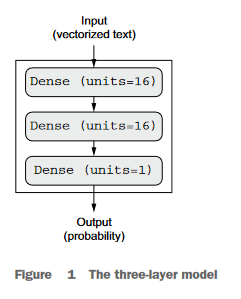

We will now show the Keras implementation.



**Model definition**

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    # TODO - What should the activation function be here? How many units should be in this layer? 
    # layers.
])

The  first  argument  being  passed  to  each  Dense  layer  is  the  number  of  units  in  the layer:  the  dimensionality  of  representation  space  of  the  layer.  You  can recall that each such Dense layer with a relu activation implements the following chain of tensor operations:

`output = relu(dot(input, W) + b)`

Having 16 units means the weight matrix W will have shape `(input_dimension, 16)`:
the dot product with W will project the input data onto a 16-dimensional representation space (and then you'll add the bias vector `b` and apply the `relu` operation). You can  intuitively  understand  the  dimensionality  of  your  representation  space  as  “how much freedom you're allowing the model to have when learning internal representations.”  Having  more  units  (a higher-dimensional  representation  space)  allows  your model to learn more-complex representations, but it makes the model more computationally  expensive  and  may  lead  to  learning  unwanted  patterns  (patterns  that  will improve performance on the training data but not on the test data).

The  intermediate  layers  use `relu`  as  their  activation  function,  and  the  final  layer uses a `sigmoid` activation so as to output a probability (a score between 0 and 1 indicating how likely the sample is to have the target “1”: how likely the review is to be positive). A `relu` (rectified linear unit) is a function meant to zero out negative values (see figure 2), whereas a sigmoid “squashes” arbitrary values into the `[0, 1]` interval (see figure 3), outputting something that can be interpreted as a probability.

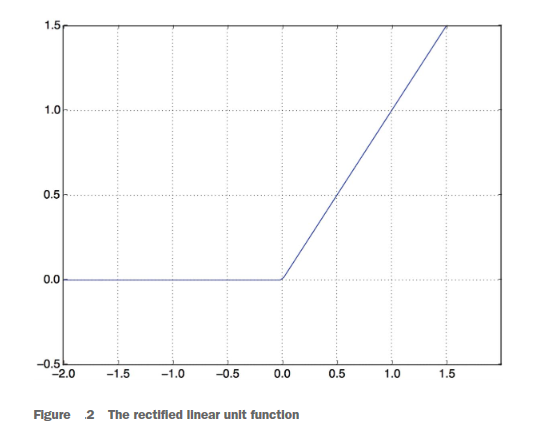

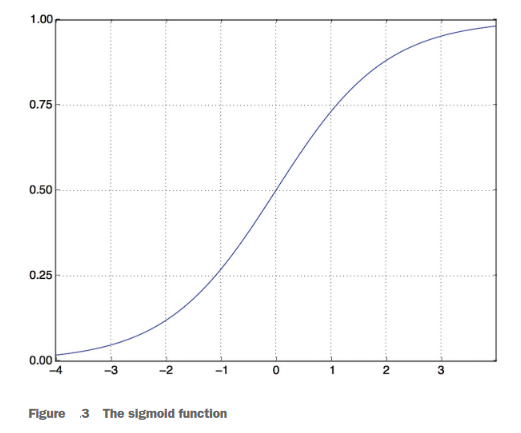

---
**What are activation functions, and why are they necessary?**


Without an activation function like `relu` (also called a non-linearity), the `Dense` layer would consist of two linear operations— a dot product and an addition:

`output = dot(input, W) + b`

The layer could only learn linear transformations (affine transformations) of the input data: the hypothesis space of the layer would be the set of all possible linear transformations of the input data into a 16-dimensional space. Such a hypothesis space is  too  restricted  and  wouldn't  benefit  from  multiple  layers  of  representations, because a deep stack of linear layers would still implement a linear operation: adding more layers wouldn't extend the hypothesis space.

In order to get access to a much richer hypothesis space that will benefit from deep representations, you need a  non-linearity, or activation function. `relu` is  the  most popular activation  function  in deep learning,  but there are many other candidates, which all come with similarly strange names: `prelu`, `elu`, and so on.

---

Finally, you need to choose a loss function and an optimizer. Because you're facing a binary classification problem and the output of your model is a probability (you end your  model  with  a  single-unit  layer  with  a  sigmoid  activation),  it's  best  to  use  the `binary_crossentropy` loss. It isn't the only viable choice: for instance, you could use
`mean_squared_error`. But crossentropy is usually the best choice when you're dealing with models that output probabilities. Crossentropy is a quantity from the field of information theory that measures the distance between probability distributions or, in this case, between the ground-truth distribution and your predictions.

As for the choice of the optimizer, we'll go with `rmsprop`, which is a usually a good default choice for virtually any problem.

Here’s  the step  where  we  configure  the  model  with  the rmsprop  optimizer and the `binary_crossentropy` loss function. Note that we'll also monitor accuracy during training.

**Compiling the model**

In [ ]:
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

### Validating your approach

A deep learning model should never be evaluated on its
training data— it's standard practice to use a validation set to monitor the accuracy of the model during training. Here, we'll create a validation set by setting apart 10,000 samples from the original training data.

**Setting aside a validation set**

In [ ]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

We will now train the model for 20 epochs (20 iterations over all samples in the training data) in mini-batches of 512 samples. At the same time, we will monitor loss and accuracy on the 10,000 samples that we set apart. We do so by passing the validation data as the `validation_data` argument.

**Training your model**

In [ ]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/20
30/30 [==============================] - 7s 57ms/step - loss: 0.5502 - accuracy: 0.7554 - val_loss: 0.4194 - val_accuracy: 0.8504
Epoch 2/20
30/30 [==============================] - 1s 24ms/step - loss: 0.3375 - accuracy: 0.8909 - val_loss: 0.3194 - val_accuracy: 0.8846
Epoch 3/20
30/30 [==============================] - 1s 22ms/step - loss: 0.2484 - accuracy: 0.9181 - val_loss: 0.2895 - val_accuracy: 0.8902
Epoch 4/20
30/30 [==============================] - 1s 21ms/step - loss: 0.1989 - accuracy: 0.9339 - val_loss: 0.2953 - val_accuracy: 0.8822
Epoch 5/20
30/30 [==============================] - 1s 24ms/step - loss: 0.1653 - accuracy: 0.9464 - val_loss: 0.2940 - val_accuracy: 0.8826
Epoch 6/20
30/30 [==============================] - 1s 24ms/step - loss: 0.1406 - accuracy: 0.9566 - val_loss: 0.2917 - val_accuracy: 0.8827
Epoch 7/20
30/30 [==============================] - 1s 21ms/step - loss: 0.1199 - accuracy: 0.9639 - val_loss: 0.2968 - val_accuracy: 0.8860
Epoch 8/20
30

On CPU, this will take less than 2 seconds per epoch—training is over in 20 seconds. At the end of every epoch, there is a slight pause as the model computes its loss and accuracy on the 10,000 samples of the validation data.

Note that the call to `model.fit()` returns a History object.
This object has a member history, which is a dictionary containing data about everything that happened during training. Let's look at it:

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

The dictionary contains four entries: one per metric that was being monitored during training and during validation. In the following two listings, let's use Matplotlib to plot the training and validation loss side by side (see figure below), as well as the training and validation accuracy. 

Note that your own results may vary slightly due to
a different random initialization of your model.

**Plotting the training and validation loss**

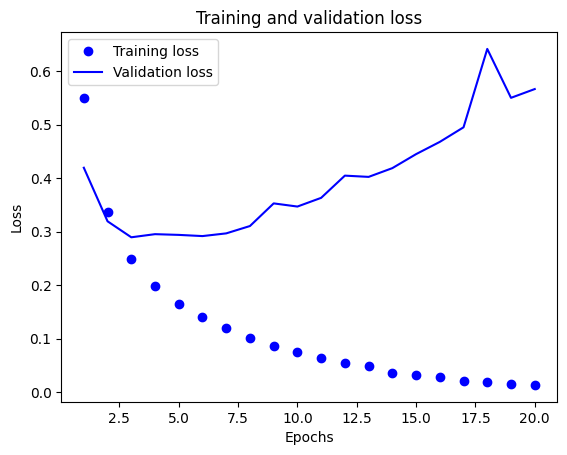

In [ ]:
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")                      # 'bo' is for a solid blue dot
plt.plot(epochs, val_loss_values, "b", label="Validation loss")                 # 'b' is for a solid blue line.
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

**Plotting the training and validation accuracy**

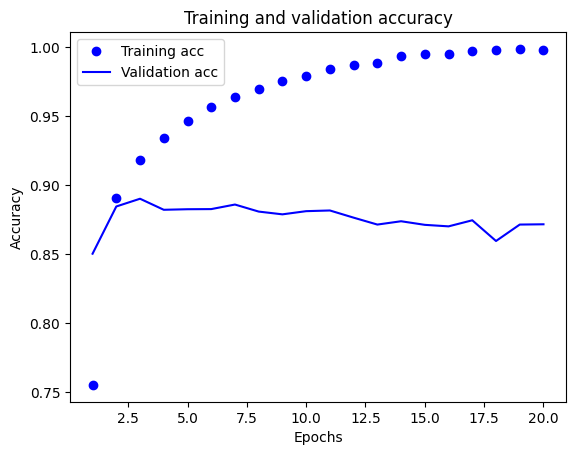

In [ ]:
plt.clf()                                                                       # Clears the figure
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

**What went wrong?**

As you can see, the training loss decreases with every epoch, and the training accuracy increases  with  every  epoch.  That's  what  you  would  expect  when  running  gradient-descent  optimization— the  quantity  you're  trying  to  minimize  should  be  less  with every iteration. But that isn't the case for the validation loss and accuracy: they seem to peak  at  the  fourth  epoch.  

This  is  an  example  of  what  can often happen:  a model  that  performs  better  on  the  training  data  isn't  necessarily  a  model  that  will
do  better  on  data  it  has  never  seen  before.  In  precise  terms,  what  you're  seeing  is **overfitting**: after the fourth epoch, you’re overoptimizing on the training data, and you end up learning representations that are specific to the training data and don't generalize to data outside of the training set.

In this case, to prevent overfitting, you could stop training after four epochs.  In general, you can use a range of techniques to mitigate overfitting.

Let's train a new model from scratch for four epochs and then evaluate it on the
test data.

**Retraining a model from scratch**

In [ ]:
model = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    # TODO - What should the activation function be here? How many units should be in this layer? 
    # layers.
])
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.fit(x_train, y_train, epochs=4, batch_size=512)
results = model.evaluate(x_test, y_test)

Epoch 1/4
49/49 [==============================] - 2s 13ms/step - loss: 0.4843 - accuracy: 0.8139
Epoch 2/4
49/49 [==============================] - 1s 12ms/step - loss: 0.2847 - accuracy: 0.9008
Epoch 3/4
49/49 [==============================] - 1s 13ms/step - loss: 0.2188 - accuracy: 0.9207
Epoch 4/4
782/782 [==============================] - 2s 3ms/step - loss: 0.2832 - accuracy: 0.8876


The final results are as follows:

In [ ]:
print("Test loss : %.2f, Test accuracy : %5.2f" % (results[0], results[1]))

Test loss : 0.28, Test accuracy :  0.89


This fairly naive approach achieves an accuracy of 88%. With state-of-the-art
approaches, you should be able to get close to 95%.

### Using a trained model to generate predictions on new data

After having trained a model, you’ll want to use it in a practical setting. You can generate  the  likelihood  of  reviews  being  positive  by  using  the  predict  method:

In [ ]:
model.predict(x_test)

782/782 [==============================] - 1s 2ms/step


array([[0.22446814],
       [0.9999505 ],
       [0.92780524],
       ...,
       [0.09579878],
       [0.09967549],
       [0.5346142 ]], dtype=float32)

As  you  can  see,  the  model  is  confident  for  some  samples  (`0.99`  or  more,  or  `0.01`  or less) but less confident for others `(0.6, 0.4)`. 

### Further experiments

The following experiments will help convince you that the architecture choices you've made are all fairly reasonable, although there's still room for improvement:

* You used two representation layers before the final classification layer. Try using
one or three representation layers, and see how doing so affects validation and
test accuracy.
* Try using layers with more units or fewer units: 32 units, 64 units, and so on.
* Try using the `mse` loss function instead of `binary_crossentropy`.
* Try using the `tanh` activation (an activation that was popular in the early days of neural networks) instead of `relu`.

### Wrapping up

Here's what you should take away from this example:
* You usually need to do quite a bit of preprocessing on your raw data in order to be able to feed it—as tensors—into a neural network. Sequences of words can
be encoded as binary vectors, but there are other encoding options too.
* Stacks of `Dense` layers with relu activations can solve a wide range of problems (including sentiment classification), and you'll likely use them frequently.
* In a binary classification problem (two output classes), your model should end
with  a  Dense  layer  with  one  unit  and  a sigmoid  activation:  the  output  of  your model should be a scalar between 0 and 1, encoding a probability.
* With  such  a  scalar  sigmoid  output  on  a  binary  classification  problem,  the  loss function you should use is `binary_crossentropy`.
* The `rmsprop` optimizer is generally a good enough choice, whatever your problem. That's one less thing for you to worry about.
* As they get better on their training data, neural networks eventually start overfitting  and  end  up  obtaining  increasingly  worse  results  on  data  they've  never seen before. Be sure to always monitor performance on data that is outside of the training set. 

## Classifying newswires: A multiclass classification example

In the previous section, you saw how to classify vector inputs into two mutually exclusive  classes  using  a  densely  connected  neural  network.  But  what  happens  when  you have more than two classes?

In this section, we'll build a model to classify Reuters newswires into 46 mutually exclusive  topics.  Because  we  have  many  classes,  this  problem  is  an  instance  of  *multi-class classification*, and because each data point should be classified into only one category, the problem is more specifically an instance of *single-label multiclass classification*.

If each data point could belong to multiple categories (in this case, topics), we'd be facing a *multilabel multiclass classification problem*.

### The Reuters dataset

We'll work with the *Reuters dataset*, a set of short newswires and their topics, published by Reuters in 1986. It's a simple, widely used toy dataset for text classification. There are 46 different topics; some topics are more represented than others, but each topic has at least 10 examples in the training set.

 Like IMDB and MNIST, the Reuters dataset comes packaged as part of Keras. Let's
take a look.

**Loading the Reuters dataset**

In [ ]:
from tensorflow.keras.datasets import reuters
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(
    num_words=10000)

2110848/2110848 [==============================] - 1s 1us/step


As  with  the  IMDB  dataset,  the  argument  `num_words=10000`  restricts  the  data  to  the 10,000 most frequently occurring words found in the data.

You have 8,982 training examples and 2,246 test examples:

In [ ]:
len(train_data)

8982

In [ ]:
len(test_data)

2246

As with the IMDB reviews, each example is a list of integers (word indices):

In [ ]:
np.array(train_data[10])

array([   1,  245,  273,  207,  156,   53,   74,  160,   26,   14,   46,
        296,   26,   39,   74, 2979, 3554,   14,   46, 4689, 4329,   86,
         61, 3499, 4795,   14,   61,  451, 4329,   17,   12])

Here’s how you can decode it back to words, in case you're curious.

**Decoding newswires back to text**

In [ ]:
word_index = reuters.get_word_index()
# TODO - What should go here?
# reverse_word_index = ?
decoded_newswire = " ".join([reverse_word_index.get(i - 3, "?") for i in        # Note that the indices are offset by 3 because 0, 1, and 2 are 
    train_data[0]])                                                             # reserved indices for padding, start of sequence, and unknown.

550378/550378 [==============================] - 1s 1us/step


In [ ]:
# Print out the English text from the decoded newswire
print(decoded_newswire[3:])

 ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


The label associated with an example is an integer between 0 and 45— a topic index:

In [ ]:
train_labels[14]

19

### Preparing the data

You can vectorize the data with the exact same code as in the previous example.

**Encoding the input data**

In [ ]:
x_train = vectorize_sequences(train_data)                                       # Vectorized training data
x_test = vectorize_sequences(test_data)                                         # Vectorized test data

To vectorize the labels, there are two possibilities: you can cast the label list as an integer tensor, or you can use *one-hot encoding*. One-hot encoding is a widely used format for  categorical  data,  also called *categorical  encoding*. In  this case, one-hot  encoding of the labels consists of embedding each label as an all-zero vector with a 1 in the place of the label index. The following listing shows an example.

**Encoding the labels**

In [ ]:
def to_one_hot(labels, dimension=46):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results
y_train = to_one_hot(train_labels)                                              # Vectorized training labels
y_test = to_one_hot(test_labels)                                                # Vectorized test labels

Note that there is a built-in way to do this in Keras:

In [ ]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(train_labels)
y_test = to_categorical(test_labels)

### Building your model

This topic-classification problem looks similar to the previous movie-review classification problem: in both cases, we're trying to classify short snippets of text. But there is a  new  constraint  here:  the  number  of  output  classes  has  gone  from  2  to  46.  The dimensionality of the output space is much larger.

In a stack of `Dense` layers like those we've been using, each layer can only access information  present  in  the  output  of  the  previous  layer.  If  one  layer  drops  some information  relevant  to  the  classification  problem,  this  information  can  never  be recovered by later layers: each layer can potentially become an information bottle-neck.  In  the previous  example, we used 16-dimensional intermediate  layers, but  a 16-dimensional  space  may  be  too  limited  to  learn  to  separate  46  different  classes:
such  small  layers  may  act  as  information  bottlenecks,  permanently  dropping  relevant information.

For this reason we'll use larger layers. Let's go with 64 units.

**Model definition**

In [ ]:
model = keras.Sequential([
    layers.Dense(64, activation="relu"),
    layers.Dense(64, activation="relu"),
    # TODO - What should the activation function be here? How many units should be in this layer?
    #layers.
])

There are two other things you should note about this architecture:
 
 * First,  we  end the model  with  a `Dense` layer  of  size 46. This means for  each  input sample,  the  network  will  output  a  46-dimensional  vector.  Each  entry  in  this  vector (each dimension) will encode a different output class.
 * Second, the last layer uses a `softmax` activation. You saw this pattern in the MNIST example. It means the model will output a *probability distribution* over the 46 different output classes—for every input sample, the model will produce a 46-dimensional output vector, where `output[i]` is the probability that the sample belongs to class i. The 46 scores will sum to 1.

 The  best  loss  function  to  use  in  this  case  is  `categorical_crossentropy`.  It  measures the distance between two probability distributions: here, between the probability distribution output by the model and the true distribution of the labels. By minimizing the distance between these two distributions, you train the model to output something as close as possible to the true labels.

**Compiling the model**

In [ ]:
model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

### Validating your approach

Let’s set apart 1,000 samples in the training data to use as a validation set.

**Setting aside a validation set**

In [ ]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]
y_val = y_train[:1000]
partial_y_train = y_train[1000:]

**Training the model**

Now, let’s train the model for 20 epochs.

In [ ]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/20
16/16 [==============================] - 2s 37ms/step - loss: 2.7698 - accuracy: 0.4743 - val_loss: 1.8789 - val_accuracy: 0.6030
Epoch 2/20
16/16 [==============================] - 0s 20ms/step - loss: 1.5671 - accuracy: 0.6647 - val_loss: 1.3955 - val_accuracy: 0.6860
Epoch 3/20
16/16 [==============================] - 0s 19ms/step - loss: 1.1963 - accuracy: 0.7374 - val_loss: 1.2002 - val_accuracy: 0.7410
Epoch 4/20
16/16 [==============================] - 0s 19ms/step - loss: 0.9670 - accuracy: 0.7967 - val_loss: 1.0865 - val_accuracy: 0.7560
Epoch 5/20
16/16 [==============================] - 0s 17ms/step - loss: 0.7999 - accuracy: 0.8311 - val_loss: 1.0116 - val_accuracy: 0.7840
Epoch 6/20
16/16 [==============================] - 0s 20ms/step - loss: 0.6646 - accuracy: 0.8629 - val_loss: 0.9389 - val_accuracy: 0.7980
Epoch 7/20
16/16 [==============================] - 0s 19ms/step - loss: 0.5519 - accuracy: 0.8847 - val_loss: 0.9124 - val_accuracy: 0.8040
Epoch 8/20
16

And finally, let’s display its loss and accuracy curves (see below).

**Plotting the training and validation loss**

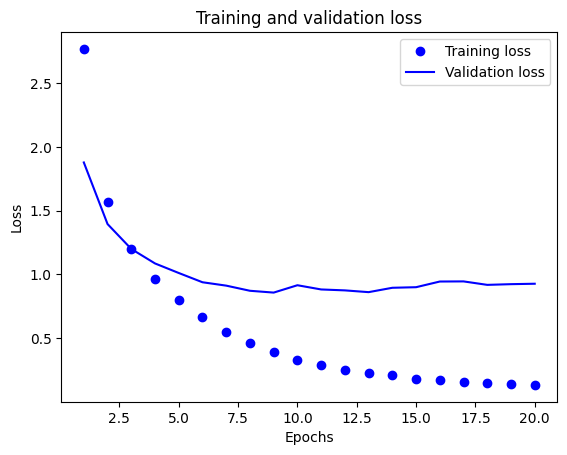

In [ ]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

**Plotting the training and validation accuracy**

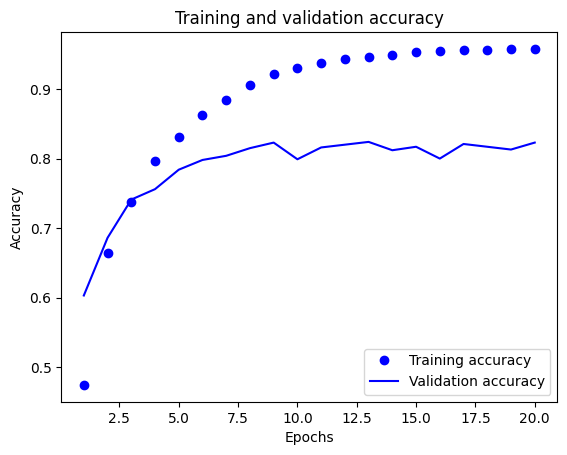

In [ ]:
plt.clf()
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

The model begins to overfit after nine epochs. Let’s train a new model from scratch for nine epochs and then evaluate it on the test set.

**Retraining a model from scratch**

In [ ]:
model = keras.Sequential([
  layers.Dense(64, activation="relu"),
  layers.Dense(64, activation="relu"),
  # TODO - What should the activation function be here? How many units should be in this layer?
  #layers.
])
model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])
model.fit(x_train,
          y_train,
          epochs=9,
          batch_size=512)
results = model.evaluate(x_test, y_test)

Epoch 1/9
18/18 [==============================] - 1s 14ms/step - loss: 2.6072 - accuracy: 0.5077
Epoch 2/9
18/18 [==============================] - 0s 13ms/step - loss: 1.4465 - accuracy: 0.6933
Epoch 3/9
18/18 [==============================] - 0s 14ms/step - loss: 1.1075 - accuracy: 0.7633
Epoch 4/9
18/18 [==============================] - 0s 13ms/step - loss: 0.9030 - accuracy: 0.8068
Epoch 5/9
18/18 [==============================] - 0s 13ms/step - loss: 0.7326 - accuracy: 0.8461
Epoch 6/9
18/18 [==============================] - 0s 12ms/step - loss: 0.6027 - accuracy: 0.8743
Epoch 7/9
18/18 [==============================] - 0s 14ms/step - loss: 0.4982 - accuracy: 0.8956
Epoch 8/9
18/18 [==============================] - 0s 13ms/step - loss: 0.4134 - accuracy: 0.9116
Epoch 9/9
71/71 [==============================] - 0s 3ms/step - loss: 0.9396 - accuracy: 0.7943


Here are the final results:

In [ ]:
print("Test loss : %.2f, Test accuracy : %5.2f" % (results[0], results[1]))

Test loss : 0.94, Test accuracy :  0.79


This  approach  reaches  an  accuracy  of  ~80%.  With  a  balanced  binary  classification problem,  the  accuracy  reached  by  a  purely  random  classifier  would  be  50%.  But  in this case, we have 46 classes, and they may not be equally represented. What would be the accuracy of a random baseline? We could try quickly implementing one to check
this empirically:

In [ ]:
import copy
test_labels_copy = copy.copy(test_labels)
np.random.shuffle(test_labels_copy)
hits_array = np.array(test_labels) == np.array(test_labels_copy)
print("Accuracy of random classifier: %.2f" % hits_array.mean())

Accuracy of random classifier: 0.19


As you can see, a random classifier would score around 19% classification accuracy, so the results of our model seem pretty good in that light.

### Generating predictions on new data

Calling the model's `predict` method on new samples returns a class probability distribution over all 46 topics for each sample. Let's generate topic predictions for all of the test data:

In [ ]:
predictions = model.predict(x_test)

71/71 [==============================] - 0s 2ms/step


Each entry in “predictions” is a vector of length 46:

In [ ]:
predictions[0].shape

(46,)

The coefficients in this vector sum to 1, as they form a probability distribution:

In [ ]:
np.sum(predictions[0])

1.0

The largest entry is the predicted class—the class with the highest probability:

In [ ]:
np.argmax(predictions[0])

3

### A different way to handle the labels and the loss

We mentioned earlier that another way to encode the labels would be to cast them as an integer tensor, like this:

In [ ]:
y_train = np.array(train_labels)
y_test = np.array(test_labels)

The only thing this approach would change is the choice of the loss function. The loss function used above, `categorical_crossentropy`, expects the labels to follow a categorical  encoding.  With  integer  labels,  you  should  use `sparse_categorical_crossentropy`:

In [ ]:
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

This new loss function is still mathematically the same as `categorical_crossentropy`; it just has a different interface. 

### The importance of having sufficiently large intermediate layers

We mentioned earlier that because the final outputs are 46-dimensional, you should avoid intermediate layers with many fewer than 46 units. Now let’s see what happens when we introduce an information bottleneck by having intermediate layers that are significantly less than 46-dimensional: for example, 4-dimensional.

**A model with an information bottleneck**

In [ ]:
model = keras.Sequential([
    layers.Dense(64, activation="relu"),
    layers.Dense(4, activation="relu"),
    # TODO - What should the activation function be here?
    #layers.
])
model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])
model.fit(partial_x_train,
          partial_y_train,
          epochs=20,
          batch_size=128,
          validation_data=(x_val, y_val))

Epoch 1/20
63/63 [==============================] - 2s 10ms/step - loss: 3.2504 - accuracy: 0.1992 - val_loss: 2.5321 - val_accuracy: 0.3110
Epoch 2/20
63/63 [==============================] - 0s 6ms/step - loss: 2.0105 - accuracy: 0.4897 - val_loss: 1.6221 - val_accuracy: 0.6470
Epoch 3/20
63/63 [==============================] - 0s 6ms/step - loss: 1.3770 - accuracy: 0.6774 - val_loss: 1.3350 - val_accuracy: 0.6710
Epoch 4/20
63/63 [==============================] - 0s 5ms/step - loss: 1.1707 - accuracy: 0.6983 - val_loss: 1.2718 - val_accuracy: 0.6720
Epoch 5/20
63/63 [==============================] - 0s 6ms/step - loss: 1.0603 - accuracy: 0.7125 - val_loss: 1.2462 - val_accuracy: 0.6880
Epoch 6/20
63/63 [==============================] - 0s 6ms/step - loss: 0.9756 - accuracy: 0.7349 - val_loss: 1.2119 - val_accuracy: 0.6980
Epoch 7/20
63/63 [==============================] - 0s 6ms/step - loss: 0.9053 - accuracy: 0.7638 - val_loss: 1.2078 - val_accuracy: 0.7140
Epoch 8/20
63/63 [=

The model now peaks at ~71% validation accuracy, an 8% absolute drop. This drop is mostly  due  to  the  fact  that  we're  trying  to  compress  a  lot  of  information  (enough information to recover the separation hyperplanes of 46 classes) into an intermediate space  that  is  too  low-dimensional.  The  model  is  able  to  cram  *most*  of  the  necessary information into these four-dimensional representations, but not all of it.

### Further experiments

Like in the previous example, I encourage you to try out the following experiments to train your intuition about the kind of configuration decisions you have to make with such models:

* Try using larger or smaller layers: 32 units, 128 units, and so on.
* You  used  two  intermediate  layers  before  the  final  `softmax`  classification  layer. Now try using a single intermediate layer, or three intermediate layers.

### Wrapping up

Here's what you should take away from this example:

*   If you're trying to classify data points among N classes, your model should end with a `Dense` layer of size N.
*   In a single-label, multiclass classification problem, your model should end with a `softmax` activation so that it will output a probability distribution over the  N output classes.
* Categorical  crossentropy  is  almost  always  the  loss  function  you  should  use  for such problems. It minimizes the distance between the probability distributions output by the model and the true distribution of the targets.
* There are two ways to handle labels in multiclass classification:
  - Encoding the labels via categorical encoding (also known as one-hot encoding) and using `categorical_crossentropy` as a loss function
  - Encoding the labels as integers and using the `sparse_categorical_cross-entropy` loss function
* If you need to classify data into a large number of categories, you should avoid creating information bottlenecks in your model due to intermediate layers that are too small.



## Predicting house prices: A regression example

The  two  previous  examples  were  considered  classification  problems,  where  the  goal was to predict a single discrete label of an input data point. Another common type of machine  learning  problem  is  *regression*,  which  consists  of  predicting  a  continuous value instead of a discrete label: for instance, predicting the temperature tomorrow, given  meteorological  data  or  predicting  the  time  that  a  software  project  will  take  to
complete, given its specifications.

**Note:** Don't confuse regression and the logistic regression algorithm. Confusingly, logistic regression isn't a regression algorithm— it's a classification algorithm.

### The Boston Housing Price dataset

In this section, we'll attempt to predict the median price of homes in a given Boston suburb in the mid-1970s, given data points about the suburb at the time, such as the crime rate, the local property tax rate, and so on. The dataset we'll use has an interesting difference from the two previous examples. It has relatively few data points: only 506, split between 404 training samples and 102 test samples. And each feature in the input data (for example, the crime rate) has a different scale. For instance, some values are proportions, which take values between 0 and 1, others take values between 1 and 12, others between 0 and 100, and so on.

**Loading the Boston housing dataset**

In [ ]:
from tensorflow.keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

57026/57026 [==============================] - 0s 0us/step


Let's examine the shape of the data.

In [ ]:
train_data.shape

(404, 13)

In [ ]:
test_data.shape

(102, 13)

As  you  can  see,  we  have  404  training  samples  and  102  test  samples,  each  with  13 numerical features, such as per capita crime rate, average number of rooms per dwelling, accessibility to highways, and so on.

The targets are the median values of owner-occupied homes, in thousands of dollars:

In [ ]:
train_targets

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4, 12.1,
       17.9, 23.1, 19.9, 15.7,  8.8, 50. , 22.5, 24.1, 27.5, 10.9, 30.8,
       32.9, 24. , 18.5, 13.3, 22.9, 34.7, 16.6, 17.5, 22.3, 16.1, 14.9,
       23.1, 34.9, 25. , 13.9, 13.1, 20.4, 20. , 15.2, 24.7, 22.2, 16.7,
       12.7, 15.6, 18.4, 21. , 30.1, 15.1, 18.7,  9.6, 31.5, 24.8, 19.1,
       22. , 14.5, 11. , 32. , 29.4, 20.3, 24.4, 14.6, 19.5, 14.1, 14.3,
       15.6, 10.5,  6.3, 19.3, 19.3, 13.4, 36.4, 17.8, 13.5, 16.5,  8.3,
       14.3, 16. , 13.4, 28.6, 43.5, 20.2, 22. , 23. , 20.7, 12.5, 48.5,
       14.6, 13.4, 23.7, 50. , 21.7, 39.8, 38.7, 22.2, 34.9, 22.5, 31.1,
       28.7, 46. , 41.7, 21. , 26.6, 15. , 24.4, 13.3, 21.2, 11.7, 21.7,
       19.4, 50. , 22.8, 19.7, 24.7, 36.2, 14.2, 18.9, 18.3, 20.6, 24.6,
       18.2,  8.7, 44. , 10.4, 13.2, 21.2, 37. , 30.7, 22.9, 20. , 19.3,
       31.7, 32. , 23.1, 18.8, 10.9, 50. , 19.6,  5. , 14.4, 19.8, 13.8,
       19.6, 23.9, 24.5, 25. , 19.9, 17.2, 24.6, 13

The prices are typically between \$10,000 and \$50,000. If that sounds cheap, remember that this was the mid-1970s, and these prices aren't adjusted for inflation.

### Preparing the data

It would be problematic to feed into a neural network values that all take wildly different  ranges.  The  model  might  be  able  to  automatically  adapt  to  such  heterogeneous data, but it would definitely make learning more difficult. A widespread best practice for dealing with such data is to do feature-wise normalization: for each feature in the input data (a column in the input data matrix), we subtract the mean of the feature and divide by the standard deviation, so that the feature is centered around 0 and has
a unit standard deviation. This is easily done in NumPy.

**Normalizing the data**

In [ ]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std
test_data -= mean
test_data /= std

Note  that  the  quantities  used  for  normalizing  the  test  data  are  computed  using  the training  data.  You  should  never  use  any  quantity  computed  on  the  test  data  in  your workflow, even for something as simple as data normalization.

### Building your model

Because so few samples are available, we'll use a very small model with two intermediate  layers,  each  with  64  units.  In  general,  the  less  training  data  you  have,  the  worse overfitting will be, and using a small model is one way to mitigate overfitting.

**Model definition**

In [ ]:
def build_model():
    model = keras.Sequential([                                                  # Because we need to instantiate the same model multiple times, 
        layers.Dense(64, activation="relu"),                                    # we use a function to construct it.
        layers.Dense(64, activation="relu"),
        # TODO: What should happen here? See paragraph below.
        #layers.
    ])
    model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
    return model

The model ends with a single unit and no activation (it will be a **linear layer**). This is a typical setup for scalar regression (a regression where you're trying to predict a single continuous value). Applying an activation function would constrain the range the output can take; for instance, if you applied a `sigmoid` activation function to the last layer, the model could only learn to predict values between 0 and 1. Here, because the last
layer is purely linear, the model is free to learn to predict values in any range.

Note that we compile the model with the `mse` loss function—*mean squared error*, the square of the difference between the predictions and the targets. This is a widely used loss function for regression problems.

We’re also monitoring a new metric during training: *mean absolute error* (MAE). It’s the absolute value of the difference between the predictions and the targets. For instance, an MAE of 0.5 on this problem would mean your predictions are off by \$500 on average. 

### Validating your approach using K-fold validation

To evaluate our model while we keep adjusting its parameters (such as the number of epochs used for training), we could split the data into a training set and a validation set, as we did in the previous examples. But because we have so few data points, the validation set would end up being very small (for instance, about 100 examples). As a consequence,  the  validation  scores  might  change  a  lot  depending  on  which  data points we chose for validation and which we chose for training: the validation scores might have a **high variance** with regard to the validation split. This would prevent us
from reliably evaluating our model.

The best practice in such situations is to use K-*fold* cross-validation (see figure 4). 

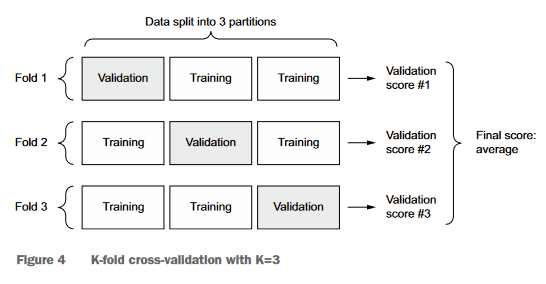

It consists of splitting the available data into K partitions (typically K = 4 or 5), instantiating K identical models, and training each one on  K - 1 partitions while evaluating on the remaining partition. The validation score for the model used is then the average of the K validation scores obtained. The code to do this is shown below.

**K-fold validation**

In [ ]:
k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
for i in range(k):
    print(f"Processing fold #{i}")
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]       # Prepares the validation data: data from partition #k
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(                                        # Prepares the training data: data from all other partitions
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    # TODO - What should partial_train_targets be following what is written above?
    #partial_train_targets = 
    model = build_model()                                                       # Builds the Keras model (already compiled)
    model.fit(partial_train_data, partial_train_targets,        
              epochs=num_epochs, batch_size=16, verbose=0)                      # Trains the model (in silent mode, verbose = 0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)         # Evaluates the model on the validation data
    all_scores.append(val_mae)

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3


Running this with `num_epochs = 100` yields the following results:

In [ ]:
all_scores

[1.9662690162658691,
 2.3146872520446777,
 2.4150357246398926,
 2.5139424800872803]

In [ ]:
np.mean(all_scores)

2.30248361825943

The different runs do indeed show rather different validation scores, from 2.1 to 3.1. The  average  (2.6)  is  a  much  more  reliable  metric  than  any  single  score—that's  the entire  point  of  K-fold  cross-validation.  In  this  case,  we're  off  by  \$2,600  on  average, which is significant considering that the prices range from \$10,000 to \$50,000.

Let's try training the model a bit longer: 500 epochs. To keep a record of how well the  model  does  at  each  epoch,  we'll  modify  the  training  loop  to  save  the  per-epoch validation score log for each fold.

**Saving the validation logs at each fold**

In [ ]:
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print(f"Processing fold #{i}")
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]       # Prepares the validation data: data from partition #k
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(                                        # Prepares the training data: data from all other partitions
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)
    model = build_model()                                                       # Builds the Keras model (already compiled)
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=16, verbose=0)            # Trains the model (in silent mode, verbose = 0)
    mae_history = history.history["val_mae"]
    all_mae_histories.append(mae_history)

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3


We can then compute the average of the per-epoch MAE scores for all folds.

**Building the history of successive mean K-fold validation scores**

In [ ]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

Let's plot this; see below.

**Plotting validation scores**

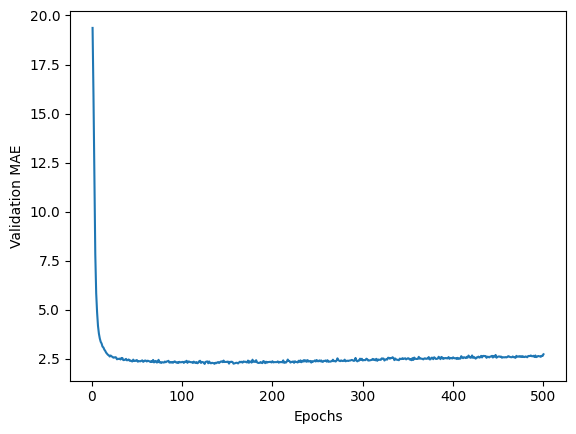

In [ ]:
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

It may be a little difficult to read the plot, due to a scaling issue: the validation MAE for the first few epochs is dramatically higher than the values that follow. Let's omit the first 10 data points, which are on a different scale than the rest of the curve.

**Plotting validation scores, excluding the first 10 data points**

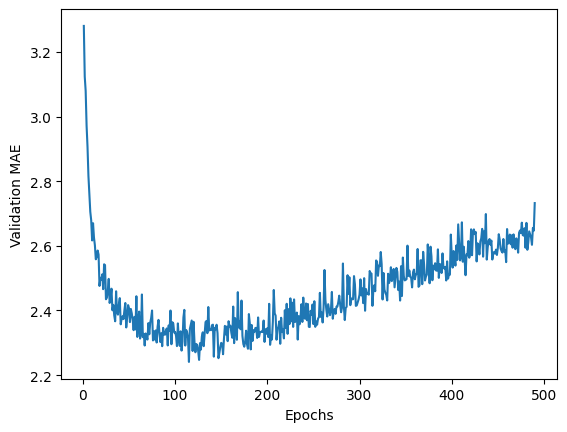

In [ ]:
truncated_mae_history = average_mae_history[10:]
plt.plot(range(1, len(truncated_mae_history) + 1), truncated_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

As  you  can  see  in  figure  4.10,  validation  MAE  stops  improving  significantly  after 120-140 epochs (this number includes the 10 epochs we omitted). Past that point, we start **overfitting**.

Once  you're  finished  tuning  other  parameters  of  the  model  (in  addition  to  the number of epochs, you could also adjust the size of the intermediate layers), you can train  a  final  production  model  on  all of  the  training data,  with  the best  parameters, and then look at its performance on the test data.

**Training the final model**

In [ ]:
model = build_model()                                                           # Obtain a fresh, compiled model
model.fit(train_data, train_targets,                                            # Trains the model on the entirety of the data
          epochs=130, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

4/4 [==============================] - 0s 4ms/step - loss: 14.7586 - mae: 2.4593


Here's the final result:

In [ ]:
test_mae_score

2.4592537879943848

We're still off by a bit under $2,500. It's an improvement! Just like with the two previous  tasks,  you  can  try  varying  the  number  of  layers  in  the  model,  or  the  number  of units per layer, to see if you can squeeze out a lower test error. 

### Generating predictions on new data

When calling `predict()` on our binary classification model, we retrieved a scalar score between 0 and 1 for each input sample. With our multiclass classification model, we retrieved a probability distribution over all classes for each sample. Now, with this scalar  regression model, `predict()` returns the  model's guess  for  the  sample's price in thousands of dollars:

In [ ]:
predictions = model.predict(test_data)
print("Value of first house: %.5f" % predictions[0])

4/4 [==============================] - 0s 2ms/step
Value of first house: 8.50147


The first house in the test set is predicted to have a price of about \$10,000. 

### Wrapping up

Here's what you should take away from this scalar regression example:

* Regression is done using different loss functions than we used for classification. Mean squared error (MSE) is a loss function commonly used for regression.
* Similarly, evaluation metrics to be used for regression differ from those used for classification; naturally, the concept of accuracy doesn't apply for regression. A common regression metric is mean absolute error (MAE).
* When  features  in  the  input  data  have  values  in  different  ranges,  each  feature should be scaled independently as a preprocessing step.
* When there is little data available, using K-fold validation is a great way to reliably evaluate a model.
* When little training data is available, it's preferable to use a small model with few intermediate layers (typically only one or two), in order to avoid severe overfitting.



## Summary


*   The  three  most  common  kinds  of  machine  learning  tasks  on  vector  data  are binary classification, multiclass classification, and scalar regression.
  * The “Wrapping up” sections earlier in the chapter summarize the important
points you've learned regarding each task.
  * Regression  uses  different  loss  functions  and  different  evaluation  metrics than classification.
* You'll usually need to preprocess raw data before feeding it into a neural network.
* When  your  data  has  features  with  different  ranges,  scale  each  feature independently as part of preprocessing.
* As  training  progresses,  neural  networks  eventually  begin  to  overfit  and  obtain worse results on never-before-seen data.
* If you don't have much training data, use a small model with only one or two
intermediate layers, to avoid severe overfitting.
* If your data is divided into many categories, you may cause information bottle-necks if you make the intermediate layers too small.
* When you're working with little data, K-fold validation can help reliably evaluate your model.



## Other Topics

Other topics include:



1.   Fundamentals of Machine Learning
  * Generalization: The goal of machine learning
  * Evaluating machine learning models
  * Improving model fit
  * Improving generalization
2.  The universal workflow of machine learning
  * Define the task
  * Develop a model
  * Deplot the model
3. Working with Keras: A deep dive
  * A spectrum of workflows
  * Different ways to build Keras models
  * Using built-in training and evaluation loops
  * Writing your own training and evaluation loops
4. Introduction to Deep learning for computer vision
  * Introduction to convnets
  * Training a convnet from scratch on a small dataset
  * Leveraging a pretrained model
5. Advanced Deep learning for computer vision
  * Three essential computer vision tasks
  * An image segmentation example
  * Modern convnet architecture patterns
  * Intrepreting what convents learn
6. Deep learning for timeseries
  * Different kinds of timeseries tasks
  * A temperature-forecasting example
  * Understanding recurrent neural networks
  * Advanced use of recurrent neural networks
7. Deep learning for text
  * Natural language processing: the bird's eye view
  * Preparing text data
  * Two approaches for representing groups of words
  * The Transformer architecture
  * Beyond text classification: Sequence-to-sequence learning
8. Generative deep learning
  * Text generation
  * DeepDream
  * Neural style transfer
  * Generating images with variational autoencoders
  * Introduction to generative adversial networks
9. Best practices for the real world
  * Getting the most out of your models
  * Scaling-up model training
10. Conclusions and Recommendations

